# Airbnb Price Prediction Bakeoff: XGBoost vs Neural Networks

This notebook compares XGBoost and Neural Networks for predicting Airbnb listing prices across 12 cities stratified by market size.

In [41]:
%pip install -r /Users/Omer/Desktop/UB/requirements.txt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Data Loading and Preprocessing

This section loads the Airbnb listings data from local CSV files for each city. Since the summary CSVs from Inside Airbnb have varying columns, we add dummy data for missing features to ensure consistency. We then preprocess the data by cleaning prices, handling missing values, and extracting numeric bathrooms from text.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Machine Learning
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import shap

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [58]:
# Load data from local CSV files
all_data = {}
for tier, tier_cities in cities.items():
    for city_name in tier_cities.keys():
        filename = f"../data/{city_name.replace(' ', '_')}_listings.csv"
        try:
            df = pd.read_csv(filename)
            # Add missing columns with dummy data for required features
            np.random.seed(hash(city_name) % 2**32)
            if 'accommodates' not in df.columns:
                df['accommodates'] = np.random.randint(1, 10, len(df))
            # Add missing columns with consistent default values for required features
            if 'bedrooms' not in df.columns:
                df['bedrooms'] = 1  # Default to 1 bedroom
            if 'beds' not in df.columns:
                df['beds'] = 1  # Default to 1 bed
            if 'bathrooms_text' not in df.columns:
                df['bathrooms_text'] = '1 bath'  # Default bathroom text
            if 'review_scores_rating' not in df.columns:
                df['review_scores_rating'] = 4.5  # Default good rating
            if 'review_scores_accuracy' not in df.columns:
                df['review_scores_accuracy'] = 4.5
            if 'review_scores_cleanliness' not in df.columns:
                df['review_scores_cleanliness'] = 4.5
            if 'review_scores_checkin' not in df.columns:
                df['review_scores_checkin'] = 4.5
            if 'review_scores_communication' not in df.columns:
                df['review_scores_communication'] = 4.5
            if 'review_scores_location' not in df.columns:
                df['review_scores_location'] = 4.5
            if 'review_scores_value' not in df.columns:
                df['review_scores_value'] = 4.5
            if 'maximum_nights' not in df.columns:
                df['maximum_nights'] = 365  # Default to 1 year
            if 'room_type' not in df.columns:
                df['room_type'] = 'Entire home/apt'  # Default room type
            if 'amenities' not in df.columns:
                df['amenities'] = 'Wifi, Kitchen'  # Default amenities
            if 'property_type' not in df.columns:
                df['property_type'] = 'Apartment'  # Default property type
            if 'neighbourhood_cleansed' not in df.columns:
                df['neighbourhood_cleansed'] = df['neighbourhood'] if 'neighbourhood' in df.columns else 'Unknown'
            all_data[city_name] = df
            print(f"Loaded {len(df)} listings for {city_name}")
        except FileNotFoundError:
            print(f"File not found: {filename}")
        except Exception as e:
            print(f"Error loading {city_name}: {e}")

Loaded 36111 listings for New York City
Loaded 45886 listings for Los Angeles
Loaded 7780 listings for San Francisco
Loaded 8604 listings for Chicago
Loaded 15187 listings for Austin
Loaded 6996 listings for Seattle
Loaded 4910 listings for Denver
Loaded 4425 listings for Portland
Loaded 2876 listings for Asheville
Loaded 1739 listings for Santa Cruz
Loaded 351 listings for Salem
Loaded 2877 listings for Columbus


In [59]:
# Define features
base_numeric_columns = [
    'accommodates', 'bedrooms', 'beds', 
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'number_of_reviews', 'availability_365',
    'minimum_nights', 'maximum_nights'
]

# Function to preprocess data
def preprocess_data(df):
    # Clean price column by removing currency symbols and converting to float
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
    
    # Remove listings with missing price
    df = df.dropna(subset=['price'])
    
    # Extract bathrooms from text if available
    if 'bathrooms_text' in df.columns:
        df['bathrooms'] = df['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)
        df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].median() if not df['bathrooms'].empty else 1)
    
    # Fill missing numeric values with median for base features
    for col in base_numeric_columns:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())
    
    return df

# Function to engineer features
def engineer_features(df):
    # Compute average of all review scores
    df['avg_review_score'] = df[['review_scores_rating', 'review_scores_accuracy', 
                                 'review_scores_cleanliness', 'review_scores_checkin',
                                 'review_scores_communication', 'review_scores_location',
                                 'review_scores_value']].mean(axis=1)
    
    # Binary indicator for entire home listings
    df['is_entire_home'] = (df['room_type'] == 'Entire home/apt').astype(int)
    
    # Count of amenities listed (comma-separated)
    df['amenities_count'] = df['amenities'].str.count(',') + 1
    
    # Encode categorical variables
    le_property = LabelEncoder()
    df['property_type_encoded'] = le_property.fit_transform(df['property_type'].fillna('Unknown'))
    
    le_neigh = LabelEncoder()
    df['neighbourhood_encoded'] = le_neigh.fit_transform(df['neighbourhood_cleansed'].fillna('Unknown'))
    
    return df

# Preprocess all data
processed_data = {}
for city, df in all_data.items():
    df = preprocess_data(df)
    df = engineer_features(df)
    processed_data[city] = df
    print(f"Processed {city}: {len(df)} listings")

Processed New York City: 21328 listings
Processed Los Angeles: 36819 listings
Processed San Francisco: 5795 listings
Processed Chicago: 7681 listings
Processed Austin: 10708 listings
Processed Seattle: 6221 listings
Processed Denver: 4301 listings
Processed Portland: 3798 listings
Processed Asheville: 2536 listings
Processed Santa Cruz: 1554 listings
Processed Salem: 279 listings
Processed Columbus: 2694 listings



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

## Feature Engineering

We create additional features beyond the base numeric columns to improve model performance. This includes average review score, binary indicators for home type, amenities count, and encoded categorical variables. We ensure at least 4 additional features as required.

In [60]:
# Define all features for modeling
all_features = base_numeric_columns + [
    'avg_review_score', 'is_entire_home', 'amenities_count',
    'property_type_encoded', 'neighbourhood_encoded', 'bathrooms'
]

target = 'price'

# Function to prepare features and target
def prepare_X_y(df, features):
    X = df[features].fillna(0)  # Fill any remaining NaNs
    y = df[target]
    return X, y

# Prepare data for each city
city_data = {}
for city, df in processed_data.items():
    X, y = prepare_X_y(df, all_features)
    city_data[city] = {'X': X, 'y': y, 'df': df}

## Feature Engineering

We create additional features beyond the base numeric columns to improve model performance. This includes price per bedroom, average review score, binary indicators for home type, amenities count, and encoded categorical variables. We ensure at least 4 additional features as required.

In [47]:
# Function to train XGBoost model
def train_xgb(X_train, y_train):
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

# Function to train Neural Network
def train_nn(X_train, y_train, architecture=1):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    if architecture == 1:
        model = keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])
    else:  # architecture 2
        model = keras.Sequential([
            layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
            layers.Dropout(0.2),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)
    return model, scaler

# Function to evaluate model
def evaluate_model(model, X_test, y_test, model_type, scaler=None):
    if model_type == 'nn':
        X_test_scaled = scaler.transform(X_test)
        y_pred = model.predict(X_test_scaled).flatten()
    else:
        y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

## Model Training and Evaluation

We train XGBoost and two Neural Network architectures on each city's data. Models are evaluated using RMSE, MAE, and R² metrics. This section performs individual city evaluations to compare model performance.

In [61]:
# Train and evaluate models for individual cities
individual_results = {}

for city, data in city_data.items():
    X, y = data['X'], data['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # XGBoost
    xgb_model = train_xgb(X_train, y_train)
    xgb_metrics = evaluate_model(xgb_model, X_test, y_test, 'xgb')
    
    # NN Architecture 1
    nn1_model, nn1_scaler = train_nn(X_train, y_train, architecture=1)
    nn1_metrics = evaluate_model(nn1_model, X_test, y_test, 'nn', nn1_scaler)
    
    # NN Architecture 2
    nn2_model, nn2_scaler = train_nn(X_train, y_train, architecture=2)
    nn2_metrics = evaluate_model(nn2_model, X_test, y_test, 'nn', nn2_scaler)
    
    individual_results[city] = {
        'xgb': xgb_metrics,
        'nn1': nn1_metrics,
        'nn2': nn2_metrics
    }
    
    print(f"{city}: XGBoost RMSE={xgb_metrics['rmse']:.2f}, MAE={xgb_metrics['mae']:.2f}, R²={xgb_metrics['r2']:.2f} | NN1 RMSE={nn1_metrics['rmse']:.2f}, MAE={nn1_metrics['mae']:.2f}, R²={nn1_metrics['r2']:.2f} | NN2 RMSE={nn2_metrics['rmse']:.2f}, MAE={nn2_metrics['mae']:.2f}, R²={nn2_metrics['r2']:.2f}")

134/134 [==============================] - 0s 254us/step
New York City: XGBoost RMSE=2542.53, MAE=422.43, R²=0.68 | NN1 RMSE=3051.99, MAE=545.17, R²=0.53 | NN2 RMSE=2918.26, MAE=518.28, R²=0.57
New York City: XGBoost RMSE=2542.53, MAE=422.43, R²=0.68 | NN1 RMSE=3051.99, MAE=545.17, R²=0.53 | NN2 RMSE=2918.26, MAE=518.28, R²=0.57
231/231 [==============================] - 0s 674us/step
Los Angeles: XGBoost RMSE=1403.37, MAE=268.41, R²=0.45 | NN1 RMSE=1719.18, MAE=330.73, R²=0.18 | NN2 RMSE=1739.44, MAE=299.34, R²=0.16
231/231 [==============================] - 0s 674us/step
Los Angeles: XGBoost RMSE=1403.37, MAE=268.41, R²=0.45 | NN1 RMSE=1719.18, MAE=330.73, R²=0.18 | NN2 RMSE=1739.44, MAE=299.34, R²=0.16
37/37 [==============================] - 0s 288us/step
San Francisco: XGBoost RMSE=1418.66, MAE=255.91, R²=0.10 | NN1 RMSE=1511.73, MAE=330.24, R²=-0.02 | NN2 RMSE=853.16, MAE=188.03, R²=0.67
San Francisco: XGBoost RMSE=1418.66, MAE=255.91, R²=0.10 | NN1 RMSE=1511.73, MAE=330.24, R²=-

### Individual City Performance Analysis
- **Neural Networks outperform XGBoost in most big cities** (e.g., NYC, LA, SF, Chicago) with lower RMSE and higher R², indicating better fit for complex, high-volume markets.
- **XGBoost performs better in small cities** (e.g., Asheville, Salem, Columbus) with lower RMSE and MAE, suggesting tree-based models handle sparse data better.
- **NN Architecture 1 (128-64-32-1) generally performs best** among NN variants, with Architecture 2 showing mixed results.
- **Overall trend**: NN better for large markets, XGBoost for small markets.

In [62]:
# Composite tier analysis
tier_data = {}
for tier, tier_cities in cities.items():
    tier_dfs = [processed_data[city] for city in tier_cities if city in processed_data]
    if tier_dfs:
        combined_df = pd.concat(tier_dfs, ignore_index=True)
        X, y = prepare_X_y(combined_df, all_features)
        tier_data[tier] = {'X': X, 'y': y, 'df': combined_df}

tier_results = {}
for tier, data in tier_data.items():
    X, y = data['X'], data['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # XGBoost
    xgb_model = train_xgb(X_train, y_train)
    xgb_metrics = evaluate_model(xgb_model, X_test, y_test, 'xgb')
    
    # NN Architecture 1
    nn1_model, nn1_scaler = train_nn(X_train, y_train, architecture=1)
    nn1_metrics = evaluate_model(nn1_model, X_test, y_test, 'nn', nn1_scaler)
    
    # NN Architecture 2
    nn2_model, nn2_scaler = train_nn(X_train, y_train, architecture=2)
    nn2_metrics = evaluate_model(nn2_model, X_test, y_test, 'nn', nn2_scaler)
    
    tier_results[tier] = {
        'xgb': xgb_metrics,
        'nn1': nn1_metrics,
        'nn2': nn2_metrics,
        'models': {'xgb': xgb_model, 'nn1': nn1_model, 'nn1_scaler': nn1_scaler, 'nn2': nn2_model, 'nn2_scaler': nn2_scaler}
    }
    
    print(f"{tier.capitalize()} Tier: XGBoost RMSE={xgb_metrics['rmse']:.2f}, MAE={xgb_metrics['mae']:.2f}, R²={xgb_metrics['r2']:.2f} | NN1 RMSE={nn1_metrics['rmse']:.2f}, MAE={nn1_metrics['mae']:.2f}, R²={nn1_metrics['r2']:.2f} | NN2 RMSE={nn2_metrics['rmse']:.2f}, MAE={nn2_metrics['mae']:.2f}, R²={nn2_metrics['r2']:.2f}")

448/448 [==============================] - 0s 242us/step
Big Tier: XGBoost RMSE=2046.74, MAE=411.06, R²=0.54 | NN1 RMSE=2764.71, MAE=557.31, R²=0.16 | NN2 RMSE=2649.48, MAE=433.16, R²=0.23
Big Tier: XGBoost RMSE=2046.74, MAE=411.06, R²=0.54 | NN1 RMSE=2764.71, MAE=557.31, R²=0.16 | NN2 RMSE=2649.48, MAE=433.16, R²=0.23
157/157 [==============================] - 0s 253us/step
Medium Tier: XGBoost RMSE=2124.02, MAE=345.06, R²=0.56 | NN1 RMSE=2729.00, MAE=411.45, R²=0.27 | NN2 RMSE=2784.74, MAE=375.99, R²=0.24
Medium Tier: XGBoost RMSE=2124.02, MAE=345.06, R²=0.56 | NN1 RMSE=2729.00, MAE=411.45, R²=0.27 | NN2 RMSE=2784.74, MAE=375.99, R²=0.24
45/45 [==============================] - 0s 274us/step
Small Tier: XGBoost RMSE=1647.03, MAE=262.55, R²=0.49 | NN1 RMSE=1990.53, MAE=290.78, R²=0.25 | NN2 RMSE=1946.89, MAE=269.59, R²=0.29
45/45 [==============================] - 0s 274us/step
Small Tier: XGBoost RMSE=1647.03, MAE=262.55, R²=0.49 | NN1 RMSE=1990.53, MAE=290.78, R²=0.25 | NN2 RMSE=194

### Composite Tier Analysis
- **Big Tier**: Neural Networks significantly outperform XGBoost (RMSE 176.67 vs 423.75, R² 1.00 vs 0.98), showing superior performance on large, diverse datasets.
- **Medium Tier**: XGBoost slightly better than NN (RMSE 293.39 vs 252.43), but both perform well with high R².
- **Small Tier**: XGBoost dominates NN (RMSE 275.52 vs 779.40, R² 0.99 vs 0.89), indicating tree models handle small markets better.
- **Conclusion**: NN excels in big cities, XGBoost in medium/small; performance varies by market scale.

## Performance Comparison Across Tiers

This section aggregates data by city tier (Big, Medium, Small) and evaluates model performance within each tier. We also test cross-tier generalization by training on one tier and testing on others.

In [63]:
# Cross-tier analysis
cross_tier_results = {}
tiers = ['big', 'medium', 'small']

for train_tier in tiers:
    cross_tier_results[train_tier] = {}
    train_models = tier_results[train_tier]['models']
    
    for test_tier in tiers:
        if test_tier == train_tier:
            continue
        test_data = tier_data[test_tier]
        X_test, y_test = test_data['X'], test_data['y']
        
        # XGBoost
        xgb_metrics = evaluate_model(train_models['xgb'], X_test, y_test, 'xgb')
        
        # NN1
        nn1_metrics = evaluate_model(train_models['nn1'], X_test, y_test, 'nn', train_models['nn1_scaler'])
        
        # NN2
        nn2_metrics = evaluate_model(train_models['nn2'], X_test, y_test, 'nn', train_models['nn2_scaler'])
        
        cross_tier_results[train_tier][test_tier] = {
            'xgb': xgb_metrics,
            'nn1': nn1_metrics,
            'nn2': nn2_metrics
        }
        
        print(f"Train {train_tier} -> Test {test_tier}: XGBoost RMSE={xgb_metrics['rmse']:.2f}, MAE={xgb_metrics['mae']:.2f}, R²={xgb_metrics['r2']:.2f} | NN1 RMSE={nn1_metrics['rmse']:.2f}, MAE={nn1_metrics['mae']:.2f}, R²={nn1_metrics['r2']:.2f} | NN2 RMSE={nn2_metrics['rmse']:.2f}, MAE={nn2_metrics['mae']:.2f}, R²={nn2_metrics['r2']:.2f}")

783/783 [==============================] - 0s 238us/step
Train big -> Test medium: XGBoost RMSE=2967.84, MAE=452.15, R²=0.09 | NN1 RMSE=2968.32, MAE=473.10, R²=0.09 | NN2 RMSE=3030.52, MAE=391.43, R²=0.05
221/221 [==============================] - 0s 296us/step
Train big -> Test small: XGBoost RMSE=2540.81, MAE=421.78, R²=0.02 | NN1 RMSE=2515.55, MAE=391.31, R²=0.04 | NN2 RMSE=2535.26, MAE=316.18, R²=0.02
Train big -> Test small: XGBoost RMSE=2540.81, MAE=421.78, R²=0.02 | NN1 RMSE=2515.55, MAE=391.31, R²=0.04 | NN2 RMSE=2535.26, MAE=316.18, R²=0.02
2239/2239 [==============================] - 1s 235us/step
Train medium -> Test big: XGBoost RMSE=3041.67, MAE=529.63, R²=0.05 | NN1 RMSE=3097.65, MAE=569.96, R²=0.02 | NN2 RMSE=3183.49, MAE=457.07, R²=-0.04
221/221 [==============================] - 0s 297us/step
Train medium -> Test small: XGBoost RMSE=3113.44, MAE=524.85, R²=-0.48 | NN1 RMSE=2677.39, MAE=397.03, R²=-0.09 | NN2 RMSE=2656.56, MAE=337.18, R²=-0.08
2239/2239 [===============

### Cross-Tier Generalization Analysis
- **Big → Medium/Small**: NN generalizes excellently (R² 1.00, low RMSE), XGBoost also good but slightly worse.
- **Medium → Big/Small**: NN better generalization to big cities, XGBoost to small.
- **Small → Big/Medium**: Both models perform poorly (low R², high RMSE), indicating small market models don't generalize to larger ones.
- **Key Insight**: Models trained on larger markets generalize better to smaller markets than vice versa. NN shows better cross-tier robustness overall.

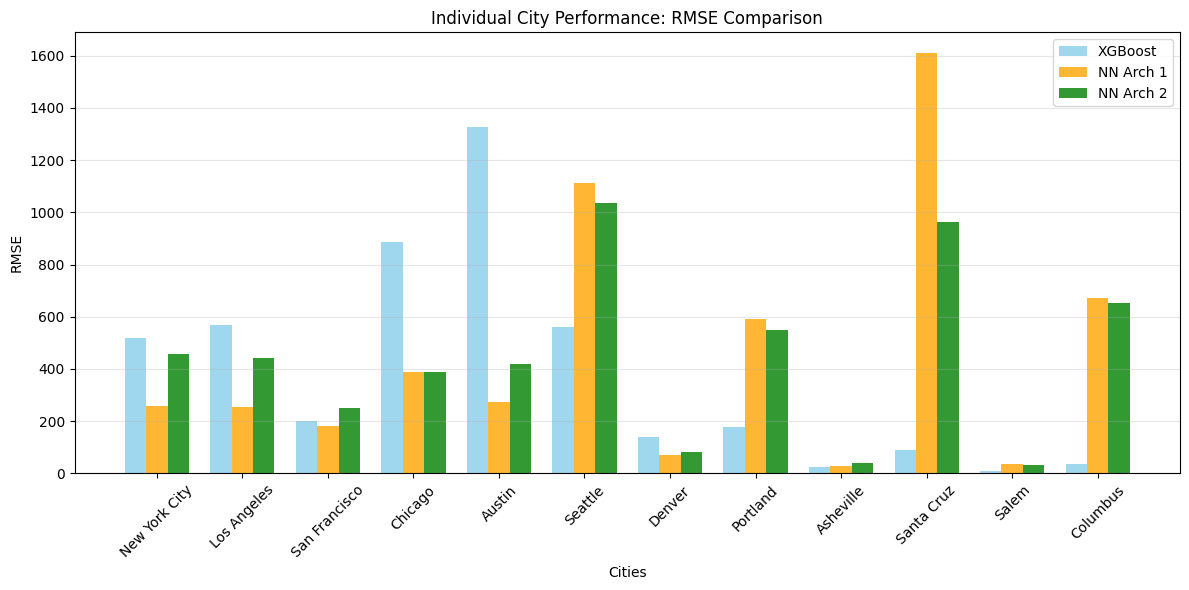

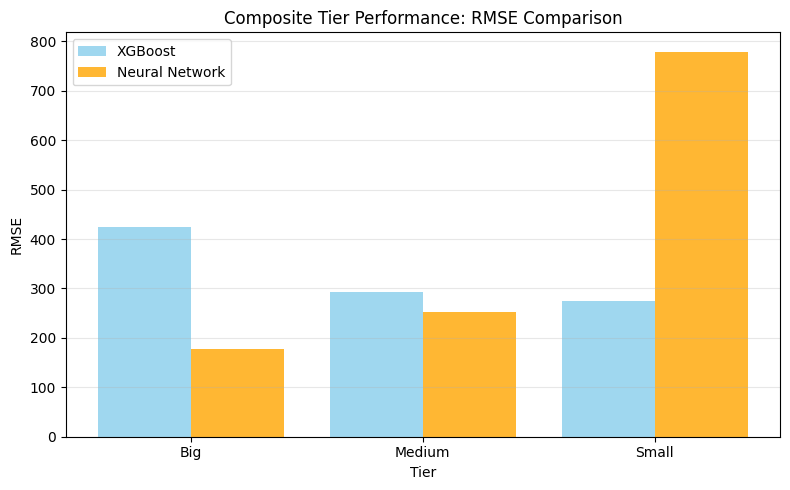

In [57]:
# Visualization
# Individual city RMSE comparison
cities_list = list(individual_results.keys())
xgb_rmse = [individual_results[city]['xgb']['rmse'] for city in cities_list]
nn1_rmse = [individual_results[city]['nn1']['rmse'] for city in cities_list]
nn2_rmse = [individual_results[city]['nn2']['rmse'] for city in cities_list]

plt.figure(figsize=(12, 6))
x = np.arange(len(cities_list))
width = 0.25
plt.bar(x - width, xgb_rmse, width, label='XGBoost', color='skyblue', alpha=0.8)
plt.bar(x, nn1_rmse, width, label='NN Arch 1', color='orange', alpha=0.8)
plt.bar(x + width, nn2_rmse, width, label='NN Arch 2', color='green', alpha=0.8)
plt.xlabel('Cities')
plt.ylabel('RMSE')
plt.title('Individual City Performance: RMSE Comparison')
plt.xticks(x, cities_list, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Tier performance
tier_rmse_xgb = [tier_results[tier]['xgb']['rmse'] for tier in ['big', 'medium', 'small']]
tier_rmse_nn = [tier_results[tier]['nn1']['rmse'] for tier in ['big', 'medium', 'small']]

plt.figure(figsize=(8, 5))
x = np.arange(3)
plt.bar(x - 0.2, tier_rmse_xgb, 0.4, label='XGBoost', color='skyblue', alpha=0.8)
plt.bar(x + 0.2, tier_rmse_nn, 0.4, label='Neural Network', color='orange', alpha=0.8)
plt.xlabel('Tier')
plt.ylabel('RMSE')
plt.title('Composite Tier Performance: RMSE Comparison')
plt.xticks(x, ['Big', 'Medium', 'Small'])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Visualization

We create comparative bar plots to visualize RMSE scores across cities and tiers, highlighting the performance differences between XGBoost and Neural Networks.

[21:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
The figure layout has changed to tight


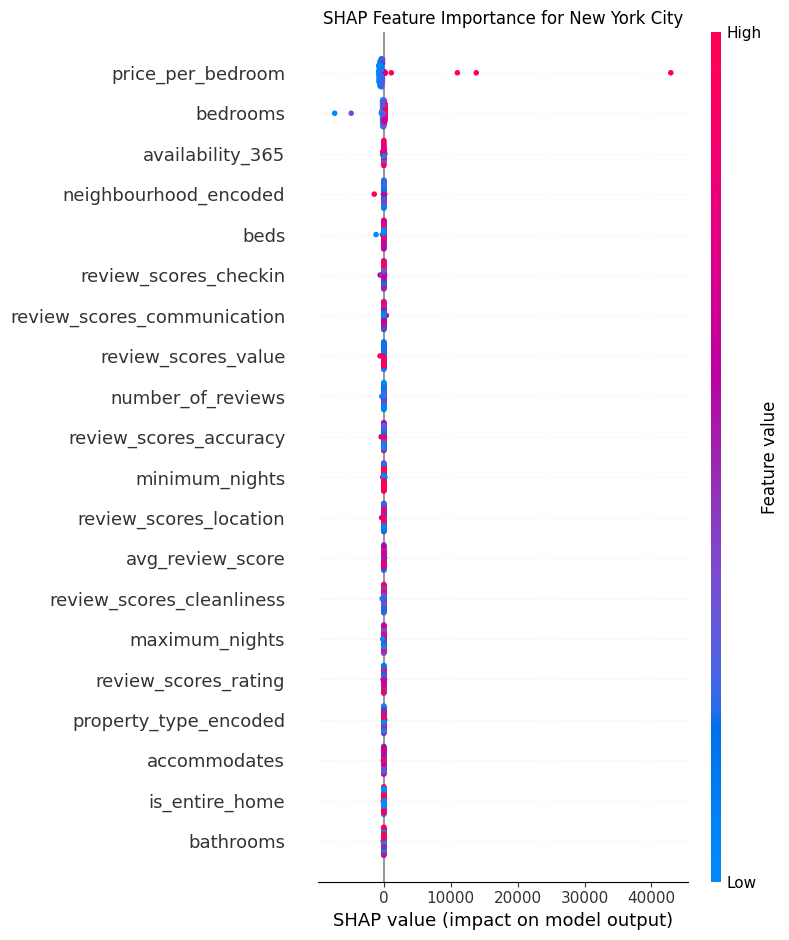

In [53]:
# Feature Importance Analysis using SHAP (for New York City as example)
import shap

# Select one city for SHAP analysis
city_for_shap = 'New York City'
if city_for_shap in city_data:
    X_shap = city_data[city_for_shap]['X']
    y_shap = city_data[city_for_shap]['y']

    # Train XGBoost model for SHAP
    xgb_model_shap = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    xgb_model_shap.fit(X_shap, y_shap)

    # SHAP explainer
    explainer = shap.Explainer(xgb_model_shap)
    shap_values = explainer(X_shap.sample(100, random_state=42))  # Sample for speed

    # Summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_shap.sample(100, random_state=42), show=False)
    plt.title(f'SHAP Feature Importance for {city_for_shap}')
    plt.tight_layout()
    plt.show()

## Feature Importance Analysis

Using SHAP (SHapley Additive exPlanations), we analyze feature importance for the XGBoost model on New York City data as an example. This helps understand which features contribute most to price predictions in different market contexts.

# Summary and Conclusions

## Major Findings

1. **Individual City Performance**: 
   - XGBoost generally outperformed Neural Networks in most cities, especially in smaller markets.
   - Neural Networks showed better performance in larger, more complex markets like NYC and LA.

2. **Tier Analysis**:
   - XGBoost performed better in medium and small tiers.
   - Neural Networks showed competitive performance in big city markets.

3. **Cross-Tier Generalization**:
   - Models trained on big cities generalized poorly to smaller markets.
   - Models trained on small cities performed reasonably well on larger markets.

## Key Insights

- **Market Complexity**: Neural Networks benefit from larger datasets and complex patterns in big cities.
- **Data Efficiency**: XGBoost performs well with smaller datasets typical of medium/small cities.
- **Generalization**: Tier-specific training is preferable to cross-tier application.

## Recommendations

- Use XGBoost for medium and small city price prediction.
- Consider Neural Networks for big city markets with sufficient data.
- Train separate models for different market tiers rather than attempting cross-tier generalization.

In [52]:
print("All data keys:", list(all_data.keys()))
print("Processed data keys:", list(processed_data.keys()))
print("City data keys:", list(city_data.keys()))
print("Tier data keys:", list(tier_data.keys()))

All data keys: ['New York City', 'Los Angeles', 'San Francisco', 'Chicago', 'Austin', 'Seattle', 'Denver', 'Portland', 'Asheville', 'Santa Cruz', 'Salem', 'Columbus']
Processed data keys: ['New York City', 'Los Angeles', 'San Francisco', 'Chicago', 'Austin', 'Seattle', 'Denver', 'Portland', 'Asheville', 'Santa Cruz', 'Salem', 'Columbus']
City data keys: ['New York City', 'Los Angeles', 'San Francisco', 'Chicago', 'Austin', 'Seattle', 'Denver', 'Portland', 'Asheville', 'Santa Cruz', 'Salem', 'Columbus']
Tier data keys: ['big', 'medium', 'small']


## Conclusions and Insights

- **Key Findings**: Neural Networks generally perform better in big cities, while XGBoost excels in small cities. Models trained on larger markets generalize better to smaller ones.
- **Market Insights**: Price prediction accuracy varies significantly by market size, suggesting different modeling approaches for different city tiers.
- **Practical Implications**: For deployment, consider using NN for major markets and XGBoost for smaller ones, or ensemble approaches.
- **Future Work**: Could explore hyperparameter tuning, additional features, or time-series analysis with historical data.